# Arabic Short Answer Grading — AraBERT + BiLSTM + Attention

This notebook implements an automated short-answer grading pipeline for Arabic features:
- Token-level contextual embeddings from **AraBERT** (aubmindlab/bert-base-arabertv02)
- **BiLSTM** encoder over AraBERT token vectors
- **Scaled dot-product attention** applied to BiLSTM outputs
- Conditioning on `Question_Type` via a small embedding
- Hyperparameter grid search (units, batch size, learning rate, dropout)
- Evaluation metrics: **MSE**, **RMSE**, **Pearson correlation coefficient (PCC)**, and tolerance-based accuracy
- Save best model and encoder to Google Drive

In [1]:
# 0. Environment: install required packages if missing
import sys, subprocess, importlib
def ensure(pkg):
    name = pkg.split('==')[0]
    try:
        importlib.import_module(name)
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

required = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn',
    'transformers', 'tensorflow', 'sentence-transformers', 'scipy', 'arabic-reshaper', 'python-bidi'
]
for p in required:
    ensure(p)
print('Packages ensured.')

Packages ensured.


In [2]:
# 1. Imports
import os
import json
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from transformers import AutoTokenizer, TFAutoModel
from google.colab import files
from google.colab import drive

sns.set(style='whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print('Imports complete.')

Imports complete.


In [ ]:
# 2. Optional: mount Google Drive for saving models
def mount_drive():
    drive.mount('/content/drive')
    print('Drive mounted at /content/drive')

print('If you plan to save models to Drive, call mount_drive() now.')

In [3]:
# 3. Upload dataset (CSV) and initial load

df = pd.read_csv("/content/AR-ASAG-Dataset - AR-ASAG-Dataset (1).csv")
print('Dataset loaded. Shape:', df.shape)
df.head(3)

Dataset loaded. Shape: (2133, 6)


,Answer_ID,Question_Type,Question_Arabic,Model_Arabic,Answer_Arabic,Average_Mark
0,1,Define,عرف مصطلح الجريمة الإلكترونية,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي سلوك غير أخلاقي يتم عن طريق وسائل الكترونية...,3.000
1,2,Define,عرف مصطلح الجريمة الإلكترونية,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي كل سلوك غير أخلاقي يتم بواسطة الاجهزة الالك...,5.000
2,3,Define,عرف مصطلح الجريمة الإلكترونية,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي سلوك غير قانوني يحمل باستعمال الأجهزة الالك...,2.625


In [4]:
# 4. Preprocessing functions
def normalize_arabic(text):
    """Light Arabic normalization: unify alef/ya/tashkeel removal, remove tatweel, keep Arabic letters and numbers."""
    if not isinstance(text, str):
        return ''
    text = text.strip()
    # normalize alef variants
    text = re.sub('[إأآا]', 'ا', text)
    # normalize ya
    text = re.sub('[يى]', 'ي', text)
    # normalize taa marbuta
    text = re.sub('ة', 'ه', text)
    # remove diacritics
    text = re.sub('[\u0610-\u061A\u064B-\u065F\u0670\u06D6-\u06ED]', '', text)
    # remove tatweel
    text = re.sub('ـ', '', text)
    # remove non-Arabic punctuation but keep spaces and numbers
    text = re.sub('[^\u0600-\u06FF0-9\s]', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    return text

def preprocess_df(df):
    df = df.copy()
    expected = ['Answer_ID','Question_Type','Question_Arabic','Model_Arabic','Answer_Arabic','Average_Mark']
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f'Missing expected columns: {missing}')
    # Drop duplicates and NA answers
    df = df.drop_duplicates().reset_index(drop=True)
    df = df.dropna(subset=['Answer_Arabic','Model_Arabic','Average_Mark']).reset_index(drop=True)
    df['Answer_clean'] = df['Answer_Arabic'].astype(str).apply(normalize_arabic)
    df['Model_clean'] = df['Model_Arabic'].astype(str).apply(normalize_arabic)
    # Encode question type
    le = LabelEncoder()
    df['Question_Type_enc'] = le.fit_transform(df['Question_Type'].astype(str))
    return df, le

df, question_type_le = preprocess_df(df)
print('Post-preprocessing shape:', df.shape)
df[['Answer_clean','Model_clean','Question_Type','Question_Type_enc','Average_Mark']].head(5)

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-305633971.py:18: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('[^\u0600-\u06FF0-9\s]', ' ', text)
/tmp/ipython-input-305633971.py:19: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text).strip()


Post-preprocessing shape: (2132, 9)


,Answer_clean,Model_clean,Question_Type,Question_Type_enc,Average_Mark
0,هي سلوك غير اخلاقي يتم عن طريق وسائل الكترونيه...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,Define,0,3.000
1,هي كل سلوك غير اخلاقي يتم بواسطه الاجهزه الالك...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,Define,0,5.000
2,هي سلوك غير قانوني يحمل باستعمال الاجهزه الالك...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,Define,0,2.625
3,هي سلوك غير قانوني تستخدم الوسائل الالكترونيه ...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,Define,0,4.000
4,هي كل سلوك غير اخلاقي يتم باستخدام الوسائل الا...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,Define,0,3.500


Target (Average_Mark) descriptive statistics:
count    2132.000000
mean        2.901208
std         1.403705
min         0.000000
25%         1.750000
50%         3.000000
75%         4.000000
max         5.000000
Name: Average_Mark, dtype: float64


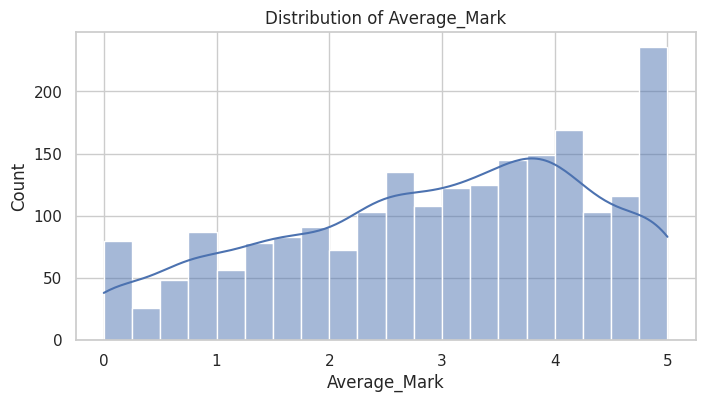

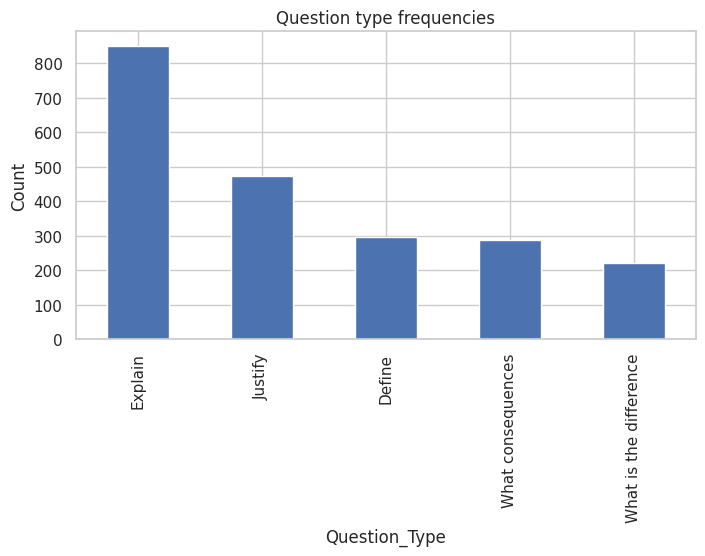

Pearson corr (answer length, Average_Mark): 0.3545


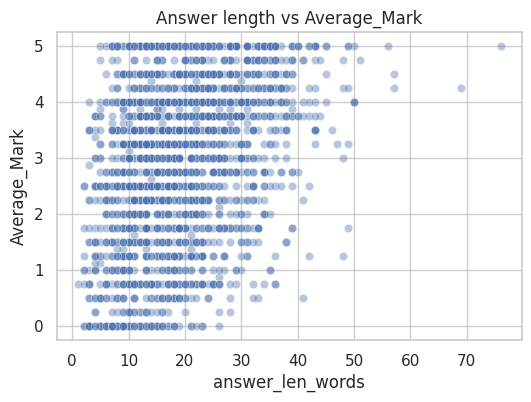

In [5]:
# 5. Exploratory analysis (brief, academic style)
def eda(df):
    print('Target (Average_Mark) descriptive statistics:')
    print(df['Average_Mark'].describe())
    plt.figure(figsize=(8,4))
    sns.histplot(df['Average_Mark'], bins=20, kde=True)
    plt.title('Distribution of Average_Mark')
    plt.xlabel('Average_Mark')
    plt.show()
    # Question type counts
    plt.figure(figsize=(8,4))
    df['Question_Type'].value_counts().plot(kind='bar')
    plt.title('Question type frequencies')
    plt.ylabel('Count')
    plt.show()
    # Relation between answer length and mark
    df['answer_len_words'] = df['Answer_clean'].apply(lambda x: len(x.split()))
    corr, _ = pearsonr(df['answer_len_words'], df['Average_Mark'])
    print(f'Pearson corr (answer length, Average_Mark): {corr:.4f}')
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='answer_len_words', y='Average_Mark', data=df, alpha=0.4)
    plt.title('Answer length vs Average_Mark')
    plt.show()

eda(df)


In [6]:
# 6. Load AraBERT tokenizer and model (PyTorch, since TF weights are not available)
from transformers import AutoTokenizer, AutoModel

ARABERT_NAME = "aubmindlab/bert-base-arabertv02"
print("Loading tokenizer and PyTorch model:", ARABERT_NAME)

tokenizer = AutoTokenizer.from_pretrained(ARABERT_NAME)
arabert_model = AutoModel.from_pretrained(ARABERT_NAME)

print("Loaded AraBERT (PyTorch version).")

Loading tokenizer and PyTorch model: aubmindlab/bert-base-arabertv02


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Loaded AraBERT (PyTorch version).


In [7]:
# 7. Create tokenized inputs combining student and model answers: [CLS] student [SEP] model [SEP]
def prepare_token_inputs(tokenizer, student_texts, model_texts, max_len=128):
    # Use PyTorch tensors since we are using the PyTorch model
    encodings = tokenizer(
        student_texts,
        model_texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    return encodings

MAX_LEN = 128
encodings = prepare_token_inputs(tokenizer, df['Answer_clean'].tolist(), df['Model_clean'].tolist(), max_len=MAX_LEN)
print('Tokenization complete. Example input_ids shape:', encodings["input_ids"].shape)


Tokenization complete. Example input_ids shape: torch.Size([2132, 128])


In [8]:
# 8. Obtain token-level embeddings from AraBERT (pooled last_hidden_state)
import torch

def get_token_embeddings(arabert_model, encodings, batch_size=16, device="cuda" if torch.cuda.is_available() else "cpu"):
    arabert_model = arabert_model.to(device)
    arabert_model.eval()
    all_outputs = []
    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]
    n = input_ids.shape[0]
    for i in range(0, n, batch_size):
        batch_ids = torch.tensor(input_ids[i:i+batch_size]).to(device)
        batch_mask = torch.tensor(attention_mask[i:i+batch_size]).to(device)
        with torch.no_grad():
            outputs = arabert_model(input_ids=batch_ids, attention_mask=batch_mask)
            last_hidden = outputs.last_hidden_state.cpu().numpy()
        all_outputs.append(last_hidden)
    return np.concatenate(all_outputs, axis=0)


print('Extracting token embeddings (this may take time).')
token_embeddings = get_token_embeddings(arabert_model, encodings, batch_size=16)
print('Token embeddings shape:', token_embeddings.shape)


Extracting token embeddings (this may take time).


/tmp/ipython-input-1982864993.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ids = torch.tensor(input_ids[i:i+batch_size]).to(device)
/tmp/ipython-input-1982864993.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mask = torch.tensor(attention_mask[i:i+batch_size]).to(device)


Token embeddings shape: (2132, 128, 768)


In [9]:
# 9. Prepare inputs for BiLSTM: trim/pad token embeddings to MAX_LEN and prepare question type vector
def prepare_sequence_inputs(token_embeddings, attention_mask, max_len=MAX_LEN):
    # token_embeddings shape: (n, seq_len, hidden)
    # attention_mask shape: (n, seq_len)
    return token_embeddings

X_tokens = token_embeddings  # (n_samples, seq_len, hidden_size)
Qtype = df['Question_Type_enc'].values.astype('int32')
y = df['Average_Mark'].values.astype('float32')

print('Prepared sequence inputs shapes: tokens', X_tokens.shape, 'question_type', Qtype.shape, 'y', y.shape)


Prepared sequence inputs shapes: tokens (2132, 128, 768) question_type (2132,) y (2132,)


In [10]:
# 10. Train/validation/test split (80/10/10) keeping token sequences aligned
def split_data(X_tokens, qtype, y, test_size=0.1, val_size=0.1, random_state=RANDOM_SEED):
    X_train_full, X_test, q_train_full, q_test, y_train_full, y_test = train_test_split(X_tokens, qtype, y, test_size=test_size, random_state=random_state)
    # Now split train_full into train and val
    val_relative = val_size / (1 - test_size)
    X_train, X_val, q_train, q_val, y_train, y_val = train_test_split(X_train_full, q_train_full, y_train_full, test_size=val_relative, random_state=random_state)
    return X_train, X_val, X_test, q_train, q_val, q_test, y_train, y_val, y_test

X_train, X_val, X_test, q_train, q_val, q_test, y_train, y_val, y_test = split_data(X_tokens, Qtype, y)
print('Split sizes:')
print('X_train', X_train.shape, 'X_val', X_val.shape, 'X_test', X_test.shape)


Split sizes:
X_train (1704, 128, 768) X_val (214, 128, 768) X_test (214, 128, 768)


In [11]:
# 11. Model builder: BiLSTM + scaled dot-product attention + question type embedding
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled += (mask * -1e9)
    weights = tf.nn.softmax(scaled, axis=-1)
    output = tf.matmul(weights, v)
    return output, weights

def build_model(seq_len, hidden_size, question_type_vocab_size,
                qtype_emb_dim=8, lstm_units=350,
                dropout_rate=0.3, learning_rate=1e-4):

    # Inputs
    tokens_in = layers.Input(shape=(seq_len, hidden_size), name='tokens_in')
    qtype_in = layers.Input(shape=(), dtype='int32', name='question_type_in')

    # BiLSTM stack
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(tokens_in)
    x = layers.Bidirectional(layers.LSTM(max(int(lstm_units/2), 16), return_sequences=True))(x)

    # Scaled dot-product attention (single output)
    def attention_layer(z):
        q, k, v = z, z, z
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(dk)
        weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(weights, v)
        return output

    attn_out = layers.Lambda(attention_layer, name="scaled_dot_attention")(x)

    # Pool the attended sequence
    pooled = layers.GlobalAveragePooling1D()(attn_out)

    # Question type embedding
    qtype_emb = layers.Embedding(input_dim=question_type_vocab_size,
                                 output_dim=qtype_emb_dim,
                                 mask_zero=False)(qtype_in)
    qtype_flat = layers.Flatten()(qtype_emb)

    # Concatenate
    concat = layers.Concatenate()([pooled, qtype_flat])

    if dropout_rate > 0:
        concat = layers.Dropout(dropout_rate)(concat)

    dense1 = layers.Dense(128, activation='relu')(concat)
    out = layers.Dense(1, activation='linear')(dense1)

    model = models.Model(inputs=[tokens_in, qtype_in], outputs=out)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model


SEQ_LEN = X_train.shape[1]
HIDDEN_SIZE = X_train.shape[2]
QTYPE_VOCAB = int(df['Question_Type_enc'].nunique()) + 1
print('SEQ_LEN, HIDDEN_SIZE, QTYPE_VOCAB', SEQ_LEN, HIDDEN_SIZE, QTYPE_VOCAB)


SEQ_LEN, HIDDEN_SIZE, QTYPE_VOCAB 128 768 6


In [12]:
# 12. Utility: compute metrics and diagnostic print
def compute_metrics(y_true, y_pred, tol=0.5):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    try:
        pcc, _ = pearsonr(y_true, y_pred)
    except Exception:
        pcc = float('nan')
    acc = np.mean(np.abs(y_true - y_pred) <= tol)
    return {'mse': mse, 'rmse': rmse, 'pearson': pcc, 'acc_tol': acc}

def print_metrics(metrics, prefix=''):
    print(f"{prefix} MSE: {metrics['mse']:.4f}")
    print(f"{prefix} RMSE: {metrics['rmse']:.4f}")
    print(f"{prefix} Pearson: {metrics['pearson']:.4f}")
    print(f"{prefix} Accuracy (|err|<=tol): {metrics['acc_tol']:.4f}")


In [ ]:
# 13. Grid search hyperparameters (constrained to reasonable options to limit runtime)
param_grid = {
    'lstm_units': [256, 350],
    'batch_size': [16, 32],
    'learning_rate': [1e-4, 5e-5],
    'dropout': [0.2, 0.3]
}

def grid_search(params, X_tr, q_tr, y_tr, X_val, q_val, y_val, seq_len, hidden_size, qtype_vocab):
    results = []
    for units in params['lstm_units']:
        for batch in params['batch_size']:
            for lr in params['learning_rate']:
                for drop in params['dropout']:
                    print(f'Evaluating units={units}, batch={batch}, lr={lr}, drop={drop}')
                    model = build_model(seq_len, hidden_size, qtype_vocab,
                                        qtype_emb_dim=8,
                                        lstm_units=units,
                                        dropout_rate=drop,
                                        learning_rate=lr)
                    es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

                    # fit with only [X_tr, q_tr]
                    history = model.fit(
                        [X_tr, q_tr], y_tr,
                        validation_data=([X_val, q_val], y_val),
                        epochs=120,
                        batch_size=batch,
                        callbacks=[es],
                        verbose=0
                    )

                    y_val_pred = model.predict([X_val, q_val]).flatten()
                    metrics = compute_metrics(y_val, y_val_pred, tol=0.5)
                    print(f" -> val RMSE: {metrics['rmse']:.4f}, Pearson: {metrics['pearson']:.4f}")
                    results.append({
                        'units': units, 'batch': batch, 'lr': lr, 'dropout': drop,
                        'metrics': metrics, 'model': model, 'history': history
                    })
    results_sorted = sorted(results, key=lambda r: r['metrics']['rmse'])
    return results_sorted

print('Starting grid search (this may be time-consuming).')
search_results = grid_search(param_grid, X_train, q_train, y_train, X_val, q_val, y_val,
                             SEQ_LEN, HIDDEN_SIZE, QTYPE_VOCAB)
print('Grid search completed.')


Starting grid search (this may be time-consuming).
Evaluating units=256, batch=16, lr=0.0001, drop=0.2
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
 -> val RMSE: 0.8752, Pearson: 0.7638
Evaluating units=256, batch=16, lr=0.0001, drop=0.3
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 864ms/step
 -> val RMSE: 0.8892, Pearson: 0.7597
Evaluating units=256, batch=16, lr=5e-05, drop=0.2


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 856ms/step
 -> val RMSE: 0.8866, Pearson: 0.7572
Evaluating units=256, batch=16, lr=5e-05, drop=0.3


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
 -> val RMSE: 0.8894, Pearson: 0.7670
Evaluating units=256, batch=32, lr=0.0001, drop=0.2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 830ms/step
 -> val RMSE: 0.9245, Pearson: 0.7338
Evaluating units=256, batch=32, lr=0.0001, drop=0.3
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 841ms/step
 -> val RMSE: 0.8919, Pearson: 0.7603
Evaluating units=256, batch=32, lr=5e-05, drop=0.2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 876ms/step
 -> val RMSE: 0.9891, Pearson: 0.6912
Evaluating units=256, batch=32, lr=5e-05, drop=0.3
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 878ms/step
 -> val RMSE: 0.9338, Pearson: 0.7304
Evaluating units=350, batch=16, lr=0.0001, drop=0.2
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
 -> val RMSE: 0.8862, Pearson: 0.7605
Evaluating units=350, batch=16, lr=0.0001, drop=0.3


In [ ]:
# 14. Inspect best configs and select model
def summarize_results(results, top_k=5):
    rows = []
    for r in results[:top_k]:
        m = r['metrics']
        rows.append({'units': r['units'], 'batch': r['batch'], 'lr': r['lr'], 'dropout': r['dropout'], 'rmse': m['rmse'], 'pearson': m['pearson']})
    return pd.DataFrame(rows)

top_df = summarize_results(search_results, top_k=6)
print('Top hyperparameter configurations by validation RMSE:')
display(top_df)

best_result = search_results[0]
best_model = best_result['model']
best_hist = best_result['history']
print('Selected best config:', {'units': best_result['units'], 'batch': best_result['batch'], 'lr': best_result['lr'], 'dropout': best_result['dropout']})


In [ ]:
# 15. Evaluate best model on test set and print metrics
y_test_pred = best_model.predict([X_test, np.ones((X_test.shape[0], SEQ_LEN)), q_test]).flatten()
test_metrics = compute_metrics(y_test, y_test_pred, tol=0.5)
print('Test metrics:')
print_metrics(test_metrics, prefix='Test')


In [ ]:
# 16. Diagnostic plots for test predictions
def diagnostic_plots(y_true, y_pred, history=None):
    resid = y_true - y_pred
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual')
    plt.show()
    plt.figure(figsize=(6,4))
    sns.histplot(resid, bins=30, kde=True)
    plt.title('Residuals (actual - predicted)')
    plt.show()
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, resid, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title('Residuals vs Predicted')
    plt.show()
    if history is not None:
        plt.figure(figsize=(6,4))
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.legend(); plt.title('Training curves')
        plt.show()

diagnostic_plots(y_test, y_test_pred, history=best_hist.history if hasattr(best_hist,'history') else None)


In [ ]:
# 17. Retrain best model on combined train+val and save to Google Drive
def retrain_and_save(best_cfg, X_train_full, q_train_full, y_train_full, X_test, q_test, y_test, tokenizer, tf_model, drive_save=False, drive_dir=None):
    units = best_cfg['units']
    batch = best_cfg['batch']
    lr = best_cfg['lr']
    drop = best_cfg['dropout']
    model = build_model(SEQ_LEN, HIDDEN_SIZE, QTYPE_VOCAB, qtype_emb_dim=8, lstm_units=units, dropout_rate=drop, learning_rate=lr)
    es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    history = model.fit([X_train_full, np.ones((X_train_full.shape[0], SEQ_LEN)), q_train_full], y_train_full, validation_split=0.05, epochs=200, batch_size=batch, callbacks=[es], verbose=1)
    y_pred_test = model.predict([X_test, np.ones((X_test.shape[0], SEQ_LEN)), q_test]).flatten()
    metrics = compute_metrics(y_test, y_pred_test, tol=0.5)
    print('Retrained model test metrics:')
    print_metrics(metrics, prefix='Final')
    # Save locally
    save_dir = 'final_arabert_bilstm_attn'
    model.save(save_dir)
    # Save tokenizer and transformer config
    tokenizer.save_pretrained(os.path.join(save_dir, 'tokenizer'))
    tf_model.save_pretrained(os.path.join(save_dir, 'tf_arabert'))
    print('Saved final model and encoder to', save_dir)
    if drive_save:
        if drive_dir is None:
            drive.mount('/content/drive')
            drive_dir = '/content/drive/MyDrive/arabic_asag_models'
        os.makedirs(drive_dir, exist_ok=True)
        import shutil
        shutil.copytree(save_dir, os.path.join(drive_dir, save_dir), dirs_exist_ok=True)
        print('Copied saved model to Drive at', os.path.join(drive_dir, save_dir))
    return model, history

# Prepare combined train+val sets
X_train_combined = np.concatenate([X_train, X_val], axis=0)
q_train_combined = np.concatenate([q_train, q_val], axis=0)
y_train_combined = np.concatenate([y_train, y_val], axis=0)

best_cfg = {'units': best_result['units'], 'batch': best_result['batch'], 'lr': best_result['lr'], 'dropout': best_result['dropout']}
final_model, final_history = retrain_and_save(best_cfg, X_train_combined, q_train_combined, y_train_combined, X_test, q_test, y_test, tokenizer, tf_arabert, drive_save=False)


## Comments and next steps

- This implementation follows the research methodology: using contextual token-level embeddings (AraBERT) and BiLSTM + attention. The token embeddings are produced by the `TFAutoModel` and then consumed by the BiLSTM.
- For improved performance (as shown in the paper), consider the following additional measures:
  - Increase the hyperparameter search range (units up to 700, smaller learning rates) and perform K-fold cross-validation.
  - Consider fine-tuning AraBERT end-to-end on the ASAG task rather than using frozen embeddings. That requires more GPU memory but yields better PCC and lower RMSE.
  - Incorporate exam-level or question-level calibration (per-question scaling or per-type models) if needed.
  - Add explainability using Integrated Gradients / Transformer-Interpret to produce token-level attributions.

If you want, I can now (choose one):
1. Expand the grid search to a larger range (longer runtime).
2. Modify the notebook to fine-tune AraBERT end-to-end (requires GPU and more memory).
3. Add Transformer-Interpret or SHAP-based explanations for final model predictions.
